# Basic Transforms and Conversion - t|ket> example

With pytket v0.2.0 comes a selection of available `Transform` passes and subpackages to enable conversion to external data types. We now support Google Cirq, IBM Qiskit, Pyzx, ProjectQ and Rigetti pyQuil.

In this notebook, we will demonstrate a series of `Transform` passes and export to the above external frameworks. To do this, we will need to install core `pytket`, as well as the subpackage for each framework, so first run:

```
pip install pytket
pip install pytket_cirq
pip install pytket_qiskit
pip install pytket_projectq
pip install pytket_pyquil
pip install pytket_pyzx
```

Note that to use the `pytket.pyzx` converter, you must go to the PyZX github repo (https://github.com/Quantomatic/pyzx) and install from source.

Now, let us construct a pytket `Circuit` object.

In [1]:
from pytket import Circuit, OpType

In [2]:
circ = Circuit(4)
circ.T(3)
circ.S(3)
circ.CX(3,2)
circ.CX(2,1)
circ.CX(1,0)
circ.Rz(0,0.4)
circ.CX(1,0)
circ.CX(2,1)
circ.CX(3,2)
circ.T(0)
circ.Tdg(0)
circ.H(2)
circ.H(2)
circ.Sdg(3)
circ.Tdg(3)
circ.CX(0,1)
circ.CX(1,2)
circ.CX(2,3)
circ.Rz(3,1.1)
circ.CX(2,3)
circ.CX(1,2)
circ.CX(0,1)
print(circ) #prints only basic information about the Circuit

<tket::Circuit qubits=4, gates=22>


Let's copy this `Circuit` a few times. We will need these copies later.

We can get some more stats out about this `Circuit` than just what was shown in the print method above:

In [3]:
circ2 = circ.copy()
circ3 = circ.copy()

def get_stats(tkcirc):
    print("Circuit depth = ", tkcirc.depth())
    print("Circuit CX count = ", tkcirc.n_gates_of_type(OpType.CX))
    print("Circuit CX depth = ", tkcirc.depth_by_type(OpType.CX))

get_stats(circ)

Circuit depth =  17
Circuit CX count =  12
Circuit CX depth =  11


We can also visualise the `Circuit` using, for example, IBM Qiskit's `QuantumCircuit` printer. To do this, we must use the `pytket.qiskit` subpackage and import a method from within Qiskit.

In [4]:
from pytket.qiskit import tk_to_qiskit

In [5]:
def print_tkcirc_via_qiskit(tkcirc):
    copy_tkcirc = tkcirc.copy()
    qiskit_qcirc = tk_to_qiskit(copy_tkcirc)
    print(qiskit_qcirc)
    
print_tkcirc_via_qiskit(circ)

                            ┌───┐┌────────────┐┌───┐┌───┐┌─────┐              »
q_0: |0>────────────────────┤ X ├┤ Rz(0.4*pi) ├┤ X ├┤ T ├┤ Tdg ├───■──────────»
                       ┌───┐└─┬─┘└────────────┘└─┬─┘├───┤└─────┘ ┌─┴─┐        »
q_1: |0>───────────────┤ X ├──■──────────────────■──┤ X ├────────┤ X ├────────»
                  ┌───┐└─┬─┘                        └─┬─┘ ┌───┐  ├───┤  ┌───┐ »
q_2: |0>──────────┤ X ├──■────────────────────────────■───┤ X ├──┤ H ├──┤ H ├─»
        ┌───┐┌───┐└─┬─┘                                   └─┬─┘ ┌┴───┴┐┌┴───┴┐»
q_3: |0>┤ T ├┤ S ├──■───────────────────────────────────────■───┤ Sdg ├┤ Tdg ├»
        └───┘└───┘                                              └─────┘└─────┘»
«                                            
«q_0: ────────────────────────────────────■──
«                                       ┌─┴─┐
«q_1: ──■────────────────────────────■──┤ X ├
«     ┌─┴─┐                        ┌─┴─┐└───┘
«q_2: ┤ X ├──■──────────────────■──┤ X ├─────
«   

This is a `Circuit` consisting of two sequential "phase-gadgets", consisting of Z-rotations inside CX ladders. There are some local gates between the two phase-gadgets. This `Circuit` has structure similar to what can be generated for molecular quantum chemistry.

We will now perform some `Transform` passes on our `Circuit`. To do this we need to import the `Transform` class.

In [6]:
from pytket import Transform

The first `Transform` we will use is for cleaning up the obvious obsolete gates (`T`,`Tdg`,`H`) in between the phase-gadgets.

In [7]:
Transform.RemoveRedundancies().apply(circ)

True

As you can see, the `Transform` pass, when applied to a `Circuit`, returns a bool. This bool tells you whether or not the pass performed a successful rewrite rule on the `Circuit` - using the same visualisation method as before, we can show that it has successfully removed the trivial redundant gates. 

In [8]:
print_tkcirc_via_qiskit(circ)

                            ┌───┐┌────────────┐┌───┐                        »
q_0: |0>────────────────────┤ X ├┤ Rz(0.4*pi) ├┤ X ├───────■────────────────»
                       ┌───┐└─┬─┘└────────────┘└─┬─┘┌───┐┌─┴─┐              »
q_1: |0>───────────────┤ X ├──■──────────────────■──┤ X ├┤ X ├───■──────────»
                  ┌───┐└─┬─┘                        └─┬─┘├───┤ ┌─┴─┐        »
q_2: |0>──────────┤ X ├──■────────────────────────────■──┤ X ├─┤ X ├────────»
        ┌───┐┌───┐└─┬─┘                                  └─┬─┘┌┴───┴┐┌─────┐»
q_3: |0>┤ T ├┤ S ├──■──────────────────────────────────────■──┤ Sdg ├┤ Tdg ├»
        └───┘└───┘                                            └─────┘└─────┘»
«                                       
«q_0: ───────────────────────────────■──
«                                  ┌─┴─┐
«q_1: ──────────────────────────■──┤ X ├
«                             ┌─┴─┐└───┘
«q_2: ──■──────────────────■──┤ X ├─────
«     ┌─┴─┐┌────────────┐┌─┴─┐└───┘     
«q_3: ┤ X ├

However, there are still some spare `S`, `Sdg`, `T` and `Tdg` gates on qubit 3. These can be commuted through the `CX` gates, and this can be demonstrated by our next pass.

In [9]:
Transform.CommuteRzRxThroughCX().apply(circ)
print_tkcirc_via_qiskit(circ)

                                          ┌───┐┌────────────┐┌───┐          »
q_0: |0>──────────────────────────────────┤ X ├┤ Rz(0.4*pi) ├┤ X ├───────■──»
                                     ┌───┐└─┬─┘└────────────┘└─┬─┘┌───┐┌─┴─┐»
q_1: |0>─────────────────────────────┤ X ├──■──────────────────■──┤ X ├┤ X ├»
                                ┌───┐└─┬─┘                        └─┬─┘├───┤»
q_2: |0>────────────────────────┤ X ├──■────────────────────────────■──┤ X ├»
        ┌───┐┌───┐┌─────┐┌─────┐└─┬─┘                                  └─┬─┘»
q_3: |0>┤ T ├┤ S ├┤ Sdg ├┤ Tdg ├──■──────────────────────────────────────■──»
        └───┘└───┘└─────┘└─────┘                                            »
«                                            
«q_0: ────────────────────────────────────■──
«                                       ┌─┴─┐
«q_1: ──■────────────────────────────■──┤ X ├
«     ┌─┴─┐                        ┌─┴─┐└───┘
«q_2: ┤ X ├──■──────────────────■──┤ X ├─────
«     └───┘┌─┴─┐┌─────

We could now apply the same `RemoveRedundancies` pass as before and remove these single-qubit gates. Instead, let's take the opportunity to introduce our first `Transform` combinators:

In [10]:
new_transform = Transform.repeat(Transform.RemoveRedundancies() >> Transform.CommuteRzRxThroughCX())

The `>>` operator combines two passes sequentially. It will return `True` if either of the passes acted successfully on the `Circuit` they are applied to.

The `repeat` combinator continually applies the `Transform` it takes as an argument, and ends when this returns `False`.

Therefore, this `new_transform` pass is composed of the two from before, and continually applies them sequentially until neither of them returns `True`. We can apply this new pass to `circ2`, a copy we made earlier of our original `Circuit`.

In [11]:
new_transform.apply(circ2)
print_tkcirc_via_qiskit(circ2)

                  ┌───┐┌────────────┐┌───┐                                  »
q_0: |0>──────────┤ X ├┤ Rz(0.4*pi) ├┤ X ├───────■──────────────────────────»
             ┌───┐└─┬─┘└────────────┘└─┬─┘┌───┐┌─┴─┐                        »
q_1: |0>─────┤ X ├──■──────────────────■──┤ X ├┤ X ├──■─────────────────────»
        ┌───┐└─┬─┘                        └─┬─┘├───┤┌─┴─┐                   »
q_2: |0>┤ X ├──■────────────────────────────■──┤ X ├┤ X ├──■────────────────»
        └─┬─┘                                  └─┬─┘└───┘┌─┴─┐┌────────────┐»
q_3: |0>──■──────────────────────────────────────■───────┤ X ├┤ Rz(1.1*pi) ├»
                                                         └───┘└────────────┘»
«                    
«q_0: ────────────■──
«               ┌─┴─┐
«q_1: ───────■──┤ X ├
«          ┌─┴─┐└───┘
«q_2: ──■──┤ X ├─────
«     ┌─┴─┐└───┘     
«q_3: ┤ X ├──────────
«     └───┘          


As you can see, all trivial gates have been removed, and we are left with only the phase-gadgets. Now we can use a more industrial-strength pass. This pass will match the phase-gadgets and optimise them, using techniques from our paper: https://arxiv.org/abs/1906.01734.

Note: this pass will automatically do the `RemoveRedundancies` and `CommuteRzRxThroughCX` passes as part of its routine, as well as some others.

Using our `circ3` copy of the original `Circuit`:

In [12]:
Transform.OptimisePhaseGadgets().apply(circ3)
print_tkcirc_via_qiskit(circ3)

                                          
q_0: |0>──■────────────────────────────■──
        ┌─┴─┐┌───┐┌────────────┐┌───┐┌─┴─┐
q_1: |0>┤ X ├┤ X ├┤ U1(1.5*pi) ├┤ X ├┤ X ├
        ├───┤└─┬─┘└────────────┘└─┬─┘├───┤
q_2: |0>┤ X ├──■──────────────────■──┤ X ├
        └─┬─┘                        └─┬─┘
q_3: |0>──■────────────────────────────■──
                                          


Much better! The phase-gadgets act on the same qubits and can therefore be combined into one, then the CX ladder can be converted to a binary tree. Note that the pass has converted the resulting `Rz` gate into a `U1`, an IBM primitive equivalent to an `Rz` gate.

Let's see some metrics now.

In [13]:
get_stats(circ3)

Circuit depth =  5
Circuit CX count =  6
Circuit CX depth =  4


We can also print each `Command` in the `Circuit`, using a simple `for` loop:

In [14]:
for command in circ3:
    command.op
    print(command)

CX q[0], q[1];
CX q[3], q[2];
CX q[2], q[1];
U1(1.5PI) q[1];
CX q[2], q[1];
CX q[0], q[1];
CX q[3], q[2];


Let's convert this `Circuit` to PyZX and use its in-built visualisation method. We will have to use additional `Transform` passes to rebase the `U1` gate to their allowed gate types.

In [15]:
import pyzx as zx
from pytket.pyzx import tk_to_pyzx, pyzx_to_tk

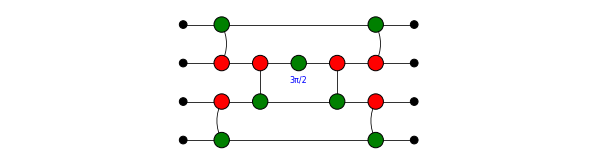

In [16]:
Transform.RebaseToPyZX().apply(circ3);
pyzx_circuit = tk_to_pyzx(circ3)
zx.draw(pyzx_circuit)

Now we are going to translate back to our `Circuit`.

In [17]:
tk_circuit = pyzx_to_tk(pyzx_circuit)
get_stats(tk_circuit)

Circuit depth =  5
Circuit CX count =  6
Circuit CX depth =  4


Let's demonstrate conversions to and from each of the other data types - Cirq, PyQuil, ProjectQ. 

For Cirq, the circuit must be on an architecture, so we have used their `GridQubit` type to allow the conversion to work:

In [18]:
import cirq
from pytket.cirq import tk_to_cirq, cirq_to_tk

Transform.RebaseToCirq().apply(tk_circuit)
qubits = [cirq.GridQubit(0, i) for i in range(4)]
cirq_circuit=tk_to_cirq(tk_circuit, qubits)

We can visualise the circuit using Cirq's tool, although sadly our rebased circuit looks very ugly!

In [19]:
print(cirq_circuit)

(0, 0): ───────────────@──────────────────────────────────────────────────────────────────────────────────────────@───────────────────
                       │                                                                                          │
(0, 1): ───Z───Y^0.5───@───Z───Y^0.5───Z───Y^0.5───@───Z───Y^0.5───S^-1───Z───Y^0.5───@───Z───Y^0.5───Z───Y^0.5───@───────Z───Y^0.5───
                                                   │                                  │
(0, 2): ───Z───Y^0.5───@───Z───Y^0.5───────────────@──────────────────────────────────@───Z───Y^0.5───@───Z───────Y^0.5───────────────
                       │                                                                              │
(0, 3): ───────────────@──────────────────────────────────────────────────────────────────────────────@───────────────────────────────


In [20]:
tk_circuit = cirq_to_tk(cirq_circuit)

For PyQuil, no architecture is required. The program we generate here could be ran on the QVM if so desired.

In [21]:
from pytket.pyquil import pyquil_to_tk, tk_to_pyquil

Transform.RebaseToQuil().apply(tk_circuit)
quil_program = tk_to_pyquil(tk_circuit) #to pyquil...

tk_circuit = pyquil_to_tk(quil_program) #...and back again

For ProjectQ, we must create an engine and allocate a `qureg` object with the correct number of qubits. We will cycle a tket `Circuit` through the ProjectQ engines and retrieve it back out at the end.

In [22]:
from projectq import MainEngine
from pytket.projectq import tk_to_projectq, tketBackendEngine

Transform.RebaseToProjectQ().apply(tk_circuit)
eng = MainEngine(backend=tketBackendEngine())
qureg = eng.allocate_qureg(tk_circuit.n_qubits)
tk_to_projectq(eng,qureg,tk_circuit) #takes 3 arguments: the Engine object, the Qubit Register and the tket Circuit
eng.flush()

tk_circuit = eng.backend.circuit #retrieve our tket Circuit from the backend engine

Finally, after all this conversion, let's show that it's still the same circuit! Note that our continual rebases may have added now-obsolete single-qubits, so we can run a quick clean-up pass. This pass does not do any major surgery of the kind `OptimisePhaseGadgets` performs, but it combines single-qubit gates into IBM's `U1`,`U2`,`U3` set and performs other basic simplifications.

In [23]:
Transform.OptimisePostRouting().apply(tk_circuit)
print_tkcirc_via_qiskit(tk_circuit)

                                          
q_0: |0>──■────────────────────────────■──
        ┌─┴─┐┌───┐┌────────────┐┌───┐┌─┴─┐
q_1: |0>┤ X ├┤ X ├┤ U1(1.5*pi) ├┤ X ├┤ X ├
        ├───┤└─┬─┘└────────────┘└─┬─┘├───┤
q_2: |0>┤ X ├──■──────────────────■──┤ X ├
        └─┬─┘                        └─┬─┘
q_3: |0>──■────────────────────────────■──
                                          
